In [1]:
import math
import matplotlib.pyplot as plt
import random
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap

## Simulation

In [2]:
def generate_STA_distance(radius):
    angle = random.uniform(0, 2 * math.pi)
    r = radius * math.sqrt(random.uniform(0, 1))
    x = r * math.cos(angle)
    y = r * math.sin(angle)
    return math.sqrt(x**2 + y**2)

In [3]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
# CR: Capture Ratio (CR=infinite = no capture, CR=0 = always capture)

def simulation(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, CR, step, gamma, r, power_scheme, p_min, p_max):
    total_power = 0
    counter_delay_slot=0
    success_sta=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax)]
    ocw[0] = ocw_min
    for n in range (1, Lmax):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for n in range(0, Lmax):
        Imax += math.ceil(ocw[n] / RA_RU)
        
#     M_i_n  = [ [0 for _ in range(Lmax)] for _ in range(0, Imax)]
#     M_i_s  = [ [0 for _ in range(Lmax)] for _ in range(0, Imax)]
#     M_i_f  = [ [0 for _ in range(Lmax)] for _ in range(0, Imax)]
    # M_i_n[n][i]
    M_i_n  = [ [0 for _ in range(Imax)] for _ in range(Lmax)]
    M_i_s  = [ [0 for _ in range(Imax)] for _ in range(Lmax)]
    M_i_f  = [ [0 for _ in range(Imax)] for _ in range(Lmax)]

    # ------------------------------------ STA setting ------------------------------------------
    # set each STA's OBO counter, obo_counter[STA1_obo_counter, STA2_obo_counter...]
    obo_counter = [random.randint(0, ocw_min) for _ in range(0, sta_amount)]
    # set STA's transmit attempt time, retrans_counter[STA1_obo_counter, STA2_obo_counter...]
    retrans_counter = [0 for _ in range(0, sta_amount)]
    # STA's distance from AP (From 0~1)
#     sta_distance = [random.uniform(0, 1) for _ in range(0, sta_amount)]
    sta_distance = [generate_STA_distance(r) for _ in range(0, sta_amount)]    
    # record STAs choosen RA-RU, sta_on_R[slot_number][STA_1, STA_26...]
    sta_on_R = [[[] for _ in range(0,RA_RU)] for _ in range(0,Imax)]
    # Accumulated station transmit power usage
    sta_power_usage = [0 for _ in range(0, sta_amount)]
    
    capture_power_ratio = 10 ** (CR / 10)
    
    sta_3_plus_cnt = 0
    sta_3_plus_cnt_s = 0
    
    # No.i slot    
    for i in range(0, Imax):
        # fix power
        sta_power = [1 for x in retrans_counter]
        # scheme 1 (random)
        if power_scheme == 1:
            sta_power = [p_min + ((p_max-p_min)/(Lmax-1)) * random.randint(0, Lmax-1) for x in retrans_counter]
#             sta_power = [2 ** random.randint(0, step-1) for _ in range(0, sta_amount)]
        # scheme 2 (ramping)
        if power_scheme == 2:
            sta_power = [p_min + ((p_max-p_min)/(Lmax-1)) * (x) for x in retrans_counter]
#             sta_power = [2 ** (x if x <= (step - 1) else (step - 1)) for x in retrans_counter]
        # scheme 3 (fixed)
        if power_scheme == 3:
            sta_power = [p_min for x in retrans_counter]
        # No.x STA
        for x in range (0,sta_amount):
            # decrease OBO counter by RA-RU number
            obo_counter[x] -= RA_RU
            # if counter <=0 select R
            if (obo_counter[x] <= 0 and retrans_counter[x] < Lmax):
                selected_R_index = random.randint(0, RA_RU-1)
                sta_on_R[i][selected_R_index].append(x)
                
                # record power usage
                sta_power_usage[x] += sta_power[x]
                M_i_n[retrans_counter[x]][i] += 1
        # check the balls in R
        for r in range(0, len(sta_on_R[i])):
            # Record power (no power control so always 1)
            for sta_index in sta_on_R[i][r]:
                total_power += sta_power[sta_index]
            # success STA
            if (len(sta_on_R[i][r]) == 1):
                success_sta_index = sta_on_R[i][r][0]
                # mark 99999 = won't trasnmit again
                obo_counter[success_sta_index] = 99999
                # record access delay slot number
                counter_delay_slot += (i+1)
                success_sta += 1
                
                M_i_s[retrans_counter[success_sta_index]][i] += 1
#                 total_power += sta_power_usage[success_sta_index]
            # 2 STA on the same R -> capture process
            elif (len(sta_on_R[i][r]) >= 2):
                max_power = 0
                max_power_idx = 0
                power_sum = 0
                for sta_index in sta_on_R[i][r]:
                    power_sum += sta_power[sta_index] / (sta_distance[sta_index] ** gamma)
                    if sta_power[sta_index] / (sta_distance[sta_index] ** gamma) > max_power:
                        max_power = sta_power[sta_index] / (sta_distance[sta_index] ** gamma)
                        max_power_idx = sta_index
                
                SIR = max_power / (power_sum - max_power)
                capture_flag = False
                if SIR > capture_power_ratio:
                    obo_counter[max_power_idx] = 99999
                    counter_delay_slot += (i+1)
                    success_sta += 1
                    capture_flag = True
                    M_i_s[retrans_counter[max_power_idx]][i] += 1
                for sta_idx in sta_on_R[i][r]:
                    if sta_idx == max_power_idx and capture_flag:
                        continue
                    else:
                        M_i_f[retrans_counter[sta_idx]][i] += 1
                        retrans_counter[sta_idx] += 1
                        if (retrans_counter[sta_idx] < Lmax):
                            obo_counter[sta_idx] = random.randint(0, ocw[retrans_counter[sta_idx]])
                # record the probability for 3+ STA collide and capture
                if (len(sta_on_R[i][r]) >= 3):
                    sta_3_plus_cnt += 1
                    if capture_flag:
                        sta_3_plus_cnt_s += 1
                
    success_probability = success_sta / sta_amount
    access_delay = 0
    if success_sta > 0:
        access_delay = (TXOP * counter_delay_slot) / success_sta
    
    utilization = success_sta / (Imax * RA_RU)
    
    average_power = 0
    if success_sta > 0:
        average_power = total_power / success_sta
#     average_power = total_power / sta_amount
#     if sta_3_plus_cnt > 0:
#         sta_3_plus_prob = sta_3_plus_cnt_s / sta_3_plus_cnt
    sta_3_plus_prob = 0
    if sta_3_plus_cnt > 0:
        sta_3_plus_prob = sta_3_plus_cnt_s / sta_amount
    
    return success_probability, access_delay, utilization, average_power, M_i_s, M_i_f, M_i_n, sta_3_plus_prob

## Analytical

In [4]:
def P_cap(Px, Py, CR, gamma):
    # calculate power ratio threshold
    slope = (Py * (10 ** (CR / 10)) / Px) ** (1 / gamma)

    if slope >= 1:
        result = (1 / slope / 2)
    elif slope < 1:
        result = 1 - slope / 2
    return result

In [5]:
def getPower(n, step, scheme, p_min, p_max):
    if scheme == 1:
        power_sum = 0
        for i in range(step):
            power_sum += p_min + ((p_max-p_min)/(step-1)) * (i)
        return power_sum / step
    elif scheme == 2:
        return p_min + ((p_max-p_min)/(step-1)) * (n-1)
    else:
        return p_min

In [6]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
# CR: Capture Ratio (CR=infinite = no capture, CR=0 = always capture)

def analytical(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, CR, gamma, p_min, p_max, scheme):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    counter_power=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
    # Ri: RA_RU number i-th slot, (Ri[i])
    Ri = [RA_RU for _ in range(0,Imax+1)]
    # M: Arrival number for i-th slot, (M[i])
    M  = [0 for _ in range(0,Imax+1)]
    # M_i: Arrival number for i-th slot and n-th transmission (M_i[n])
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Fail stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot (M_i_s_C[i])
    M_i_s_C = [0 for _ in range(0,Imax+1)]
    
    # M_i_n[n][i]
    M_i_n_ana  = [ [0 for _ in range(Imax)] for _ in range(Lmax)]
    M_i_s_ana  = [ [0 for _ in range(Imax)] for _ in range(Lmax)]
    M_i_f_ana  = [ [0 for _ in range(Imax)] for _ in range(Lmax)]
    
    
    capture_prob = 0
    for n1 in range(1, Lmax+1):
        for n2 in range(1, Lmax+1):
            # P is the power of two station
            P1 = getPower(n=n1, step=Lmax, scheme=scheme, p_min=p_min, p_max=p_max)
            P2 = getPower(n=n2, step=Lmax, scheme=scheme, p_min=p_min, p_max=p_max)
            capture_prob += P_cap(P1, P2, CR, gamma) * (1 / Lmax) * (1 / Lmax)

    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
                # record
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0
                    
                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            M[i] += M_i[i][n]
            M_i_n_ana[n-1][i-1] += M_i[i][n]
            
        #/** statistics */  
        for n in range (1, Lmax+1):
            #/** Calculate capture probability for slot i */
            if M[i] <= 0:
                break
#             print(f'{M_i[i][n]} * math.exp(-{M[i]} / {Ri[i]})')
            first_term = M_i[i][n] * math.exp(-M[i] / Ri[i])
            temp_sum = 0
            Pn = getPower(n=n, step=step, scheme=scheme, p_min=p_min, p_max=p_max)
            for k in range(1, Lmax+1):
                Pk = getPower(n=k, step=step, scheme=scheme, p_min=p_min, p_max=p_max)
                temp_sum += P_cap(Pn, Pk, CR, gamma) * (M_i[i][k] / M[i])

            second_term = (M[i] * M_i[i][n]) / Ri[i] * math.exp(-M[i] / Ri[i]) * temp_sum
            
            M_i_s[i][n] = first_term + second_term
            M_i_s_ana[n-1][i-1] += M_i_s[i][n]
            
            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_f_ana[n-1][i-1] += M_i_f[i][n]
            
            M_i_s_C[i] += M_i_s[i][n]
        
            counter_power += getPower(n=n, step=Lmax, scheme=scheme, p_min=p_min, p_max=p_max) * M_i[i][n]
        #/** performance metric */  
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    #/** success probability */
    success_probability = success_packet / sta_amount
        
    access_delay = (TXOP * counter_delay_slot) / success_packet
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    # sta*success_probability 來算 grouping的Ds
    if success_packet != 0:
        counter_power = counter_power / success_packet
    
    return Imax,success_probability,access_delay, utilization, counter_power, M_i_s_ana, M_i_f_ana, M_i_n_ana  # ,sta*success_probability

# Setting parameters

In [15]:
# samples for simulation
sample = 10000

ocw_min=127
ocw_max=127
# ocw_max=1023
# ocw_min=7
# ocw_max=31
# maximum number of trans for each packet
Lmax = 5
# number of RA-RU reserved by AP
R = 148
# capture threshold
# CR = float('inf')
CR = 3
# step for power control
step = 4
# min/max trans power
p_min = 10
p_max = 250
# power control scheme (1 -> random, 2->ramping)
scheme = 3
# pathloss exponent
gamma = 2
# service redius
r=10

T_slot = 5.673

In [12]:
def getApproxError(ana_value, simu_value):
    return abs(ana_value - simu_value) / ana_value * 100

In [16]:
# Setting ranges for M and R
# Ms = range(1, 1000)  # Range of M values
# Ms = [(i*10) for i in range(1,51)]
Ms = [(i+1) for i in range(500)]
# Rs = range(1, 200)  # Range of R values
# Rs = [(i*10) for i in range(1,21)]
Rs = [(i+1) for i in range(200)]
x = 1   # Given x value
run_times = 100  # Number of simulations per combination

# Preparing the grid
M_mesh, R_mesh = np.meshgrid(Ms, Rs)
error_mesh = np.zeros_like(M_mesh, dtype=float)

# Calculating errors for each combination of M and R
for i, R in enumerate(Rs):
    for j, M in enumerate(Ms):
        Imax,Ps,Da,U,power, MiS, MiF, M_i_n = analytical(sta_amount=M, RA_RU=R, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, gamma=gamma, p_min=p_min, p_max=p_max, scheme=scheme)
        
        ana_value = MiS[0][0]
#         simu_value = simulation(R, x, M, run_times)
        simu_value_total = 0
        for _ in range (run_times):
            success_probability, access_delay, utilization, power_usage, M_i_s, M_i_f, M_i_n, sta_3_plus_prob = simulation(sta_amount=M, RA_RU=R, Lmax=Lmax, TXOP=5.673, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, step=step, gamma=gamma, r=r, p_min=p_min, p_max=p_max, power_scheme=scheme)
            simu_value_total += M_i_s[0][0]
        simu_value = simu_value_total / run_times
        error_mesh[i, j] = getApproxError(ana_value, simu_value)

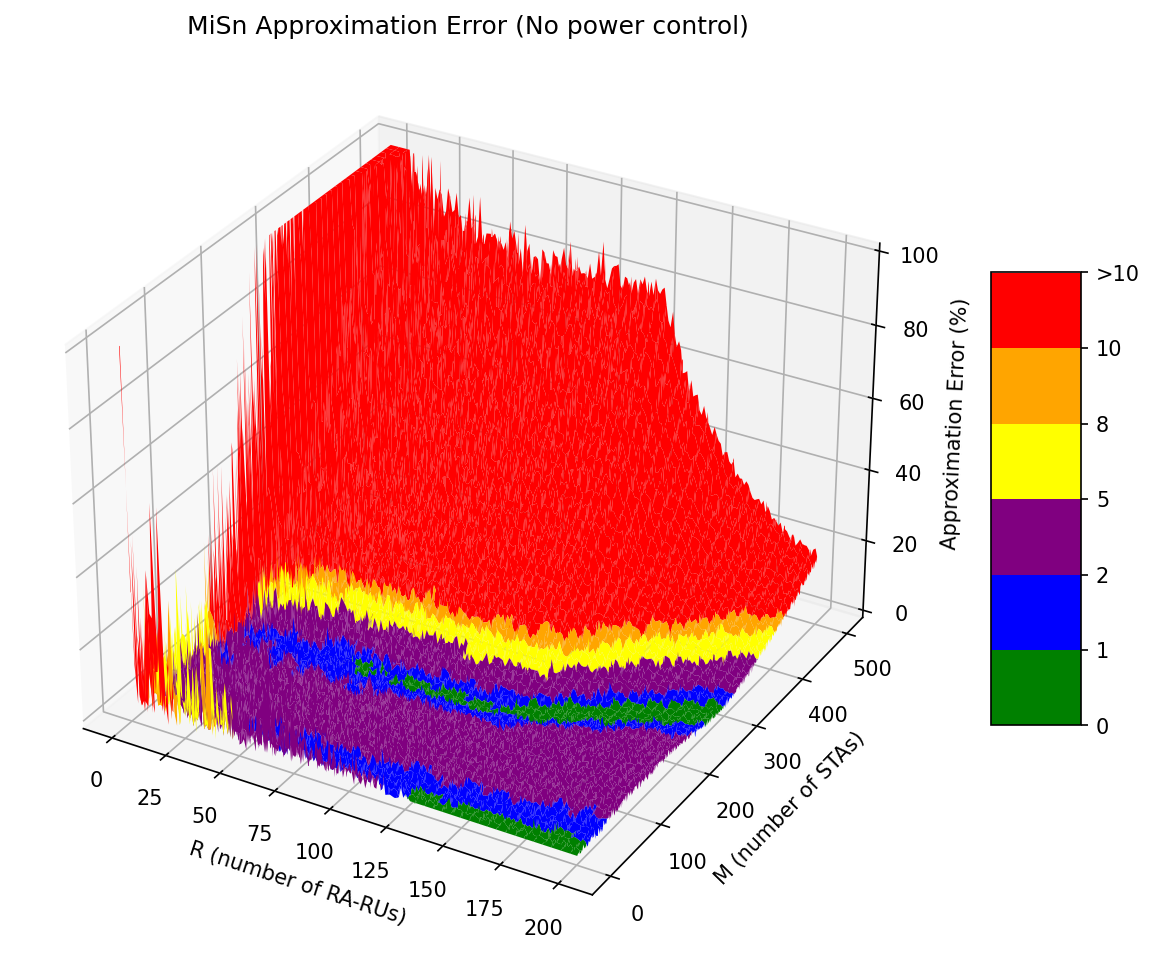

In [17]:
capped_error_mesh = np.copy(error_mesh)

capped_error_mesh[capped_error_mesh > 100] = 100

# Color Bar
# colors = ['green', 'yellow', 'orange', 'red']
colors = ['green', 'blue', 'purple', 'yellow', 'orange', 'red']
# bounds = [0, 5, 10, 50, 100]  # Define boundaries for the colors
bounds = [0, 1, 2, 5, 8, 10, 100]  # Define boundaries for the colors
custom_cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, custom_cmap.N)

fig = plt.figure(figsize=(12, 8), dpi=150)
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(R_mesh, M_mesh, capped_error_mesh, cmap=custom_cmap, norm=norm, edgecolor='none')


ax.set_xlabel('R (number of RA-RUs)')
ax.set_ylabel('M (number of STAs)')
ax.set_zlabel('Approximation Error (%)')
ax.set_title('MiSn Approximation Error (No power control)')
# fig.colorbar(surf, shrink=0.5, aspect=5)  # Color bar for error magnitude
# fig.colorbar(surf, boundaries=bounds, shrink=0.5, aspect=5)  # Add custom colorbar

ax.set_zlim(0, 100)

# Create colorbar with custom ticks and labels
cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
cbar.set_ticks([0, 1, 2, 5, 8, 10, 100])  # Set ticks to match your bounds
cbar.set_ticklabels(['0', '1', '2', '5', '8', '10', '>10'])  # Replace "100" with "10+" for display


plt.show()

In [24]:
len(R_mesh[0])

500

In [21]:
len(M_mesh[0])

500

In [23]:
len(capped_error_mesh[0])

TypeError: object of type 'numpy.float64' has no len()